# SciKit Learn for Image Classification

Today, we'll be classifying digits and butterflies in python using `sklearn`, the MNIST dataset [1] and the Leeds butterfly dataset [2].

In this notebook we'll first load our data, design the model and training procedure, and visualize our results.


[1] http://yann.lecun.com/exdb/mnist/

[2] Josiah Wang, Katja Markert, and Mark Everingham
Learning Models for Object Recognition from Natural Language Descriptions
In Proceedings of the 20th British Machine Vision Conference (BMVC2009)

## 1. Loading the Datasets

#### MNIST

MNIST can be downloaded quickly using the `sklearn.datasets` module:

In [1]:
from sklearn.datasets import fetch_openml

# Load data from https://www.openml.org/d/554
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)

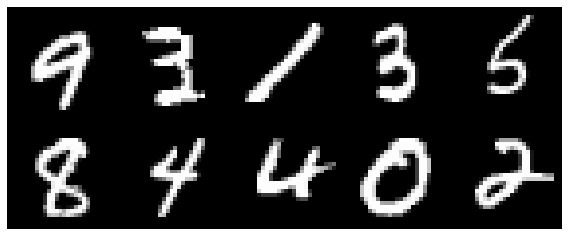

In [2]:
import numpy as np
import matplotlib.pyplot as plt
## Look at a few random examples
example_images = np.concatenate(
    (np.concatenate(
        [
          X[np.random.randint(1, high=X.shape[0]-1), :].reshape(28, 28) for _ in range(5)
        ],
        axis=1
    ),
    np.concatenate(
        [
          X[np.random.randint(1, high=X.shape[0]-1), :].reshape(28, 28) for _ in range(5)
        ],
        axis=1
    )), axis=0
  )
fig, ax = plt.subplots(figsize=(8, 4))
ax.imshow(example_images, cmap='gray')
ax.axis('off')
plt.tight_layout()


In [3]:
# preprocessing
from sklearn.utils import check_random_state
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
random_state = check_random_state(0)
permutation = random_state.permutation(X.shape[0])
X = X[permutation]
y = y[permutation]
X = X.reshape((X.shape[0], -1))
train_samples = 50000
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=train_samples, test_size=10000)

scaler = StandardScaler()
MNIST_X_train = scaler.fit_transform(X_train)
MNIST_X_test = scaler.transform(X_test)
MNIST_y_train = y_train
MNIST_y_test = y_test


#### Leeds Butterfly


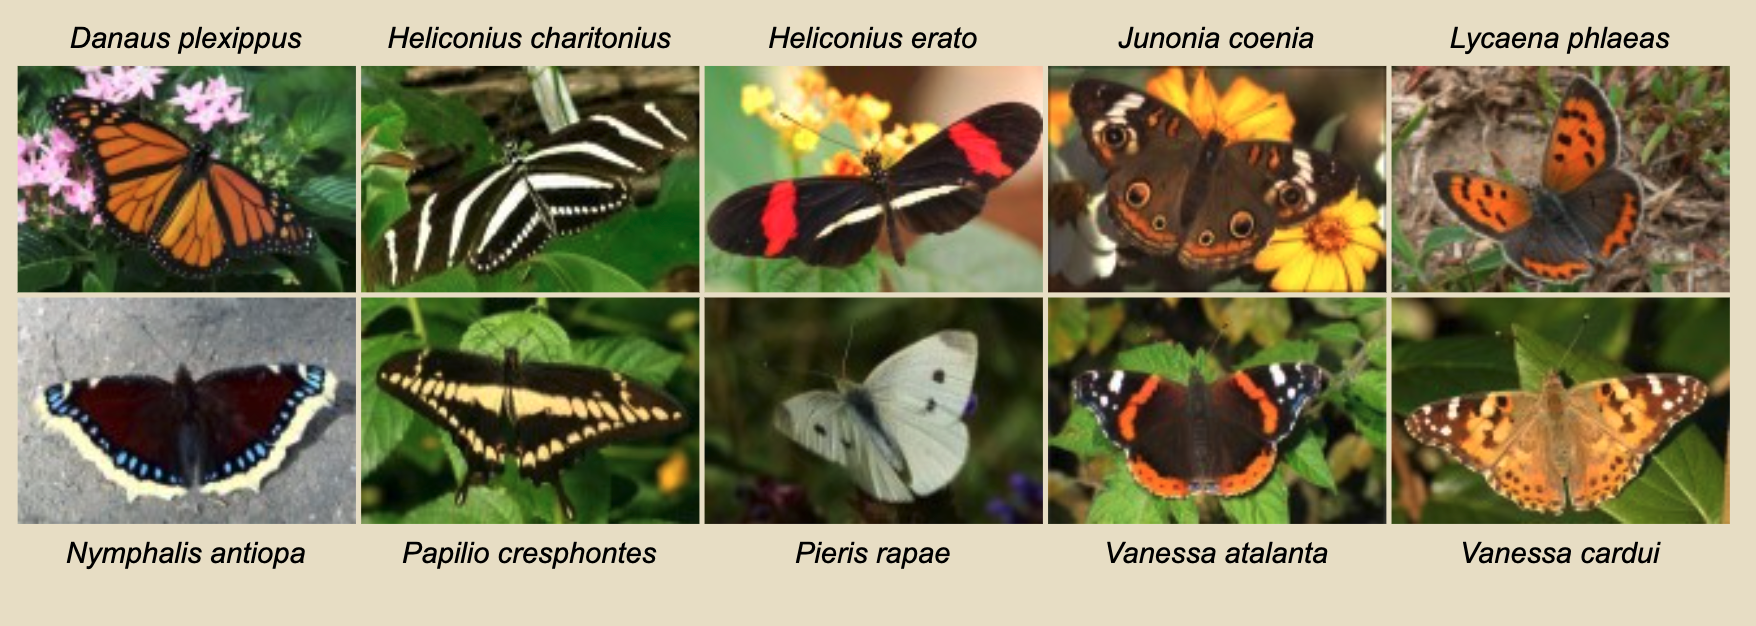


Loading this will be a bit more complicated, as this isnt a dataset that already exists in the system, so we'll create a dataloader for this dataset.

We'll load the dataset from [here](http://www.josiahwang.com/dataset/leedsbutterfly/), first downloading the zip file, extracting it, and examining the file structure.

The paradigm we're using will be similar to the way dataloaders are done in pytorch and tensorflow, which load a few examples at a time. However, you'll notice that our usage of it during training will gather the entire dataset at once rather than training a few examples at a time.

In [4]:
! wget http://www.josiahwang.com/dataset/leedsbutterfly/leedsbutterfly_dataset_v1.0.zip

--2021-02-18 15:46:16--  http://www.josiahwang.com/dataset/leedsbutterfly/leedsbutterfly_dataset_v1.0.zip
Resolving www.josiahwang.com (www.josiahwang.com)... 143.95.240.28
Connecting to www.josiahwang.com (www.josiahwang.com)|143.95.240.28|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 476389461 (454M) [application/zip]
Saving to: ‘leedsbutterfly_dataset_v1.0.zip’

leedsbutterfly_data 100%[===================>] 454.32M  17.6MB/s    in 28s     

2021-02-18 15:46:44 (16.4 MB/s) - ‘leedsbutterfly_dataset_v1.0.zip’ saved [476389461/476389461]



In [5]:
! unzip -q leedsbutterfly_dataset_v1.0.zip

In [6]:
! cat leedsbutterfly/README.txt

LEEDS BUTTERFLY DATASET (v1.0)
http://www.josiahwang.com/dataset/leedsbutterfly/

Josiah Wang, Katja Markert, and Mark Everingham

For any enquiries please email Josiah at: jw (-�t-) josiahwang.com


Version history
v1.0    29/11/2010    Initial release


Citation
If you use this dataset please cite the following work:

Josiah Wang, Katja Markert, and Mark Everingham.
"Learning Models for Object Recognition from Natural Language Descriptions".
In Proceedings of the 20th British Machine Vision Conference (BMVC2009), Sept 2009

@InProceedings{Wang09,
   title = "Learning Models for Object Recognition from Natural Language Descriptions",
   author = "Josiah Wang and Katja Markert and Mark Everingham",
   booktitle = "Proceedings of the British Machine Vision Conference",
   year = "2009"
}



Information
This ZIP archive contains:
1. 832 images for ten butterfly categories (55-100 images per category), collected from Google Images and manually filtered.
2. Segmentation masks for each imag

We see that in the `leedsbutterfly/images` folder, the images are formatted with the first 3 numbers being the category and the last 4 numbers being the image id in that category.

Additionally, the `leedsbutterfy/descriptions` folder, each category has a description with names and descriptions of each butterfly.

We need to traverse these files, collect the classnames, and generate a dictionary of images for each class.

Very quickly, lets talk about how an image classification system works.




Image of image classification

Explanation, description of what we are going to do for dataloading.

In [7]:
# Load Classnames
num_classes = 10
classes = []
for i in range(1, num_classes + 1):
  with open('leedsbutterfly/descriptions/{0:03d}.txt'.format(i)) as d_file:
    # the file has 3 lines. we'll read the firat line and ingore,
    # and grab the second line, which is the common name for each class.
    d_file.readline()
    common_name = d_file.readline().strip()
    classes.append(common_name)

print(*classes, sep='\n')
butterfly_classes = classes

Monarch
Zebra Longwing
Crimson-patched Longwing
Common Buckeye
American Copper
Mourning Cloak
Giant Swallowtail
Cabbage White
Red Admiral
Painted Lady


In [8]:
# Load Images. We'll use imageio for image loading, as well as the os package 
# to traverse the directory.
import os
from imageio import imread as imread

base_dir = 'leedsbutterfly/images'

images_dict = {
    '{0:03d}'.format(i): [] for i in range(1, num_classes + 1)
}

for image_filename in sorted(os.listdir('leedsbutterfly/images')):
  id = image_filename.split('.')[0]
  class_id = id[:3]
  class_index = id[3:]
  images_dict[class_id].append(os.path.join(base_dir, image_filename))

dataset = {}

# split 10% for validation.
for class_id in images_dict:
  images_list = images_dict[class_id]
  train_stop = int(len(images_list) * 0.9)
  train_files = images_list[:train_stop]
  validation_files = images_list[train_stop:]
  train_images = [imread(f) for f in train_files]
  validation_images = [imread(f) for f in validation_files]
  dataset[class_id] = {
      'train': train_images,
      'val': validation_images,
      'train_f': train_files,   # keep filenames for printing purposes
      'val_f': validation_files
  }

for class_id in dataset:
  print('train {}'.format(class_id), dataset[class_id]['train_f'], sep='\n')
  print('val {}'.format(class_id), dataset[class_id]['val_f'], sep='\n')
  

train 001
['leedsbutterfly/images/0010001.png', 'leedsbutterfly/images/0010002.png', 'leedsbutterfly/images/0010004.png', 'leedsbutterfly/images/0010005.png', 'leedsbutterfly/images/0010006.png', 'leedsbutterfly/images/0010007.png', 'leedsbutterfly/images/0010008.png', 'leedsbutterfly/images/0010009.png', 'leedsbutterfly/images/0010010.png', 'leedsbutterfly/images/0010011.png', 'leedsbutterfly/images/0010012.png', 'leedsbutterfly/images/0010013.png', 'leedsbutterfly/images/0010014.png', 'leedsbutterfly/images/0010015.png', 'leedsbutterfly/images/0010017.png', 'leedsbutterfly/images/0010018.png', 'leedsbutterfly/images/0010019.png', 'leedsbutterfly/images/0010020.png', 'leedsbutterfly/images/0010021.png', 'leedsbutterfly/images/0010022.png', 'leedsbutterfly/images/0010023.png', 'leedsbutterfly/images/0010024.png', 'leedsbutterfly/images/0010025.png', 'leedsbutterfly/images/0010026.png', 'leedsbutterfly/images/0010027.png', 'leedsbutterfly/images/0010028.png', 'leedsbutterfly/images/0010

In [9]:
from tqdm import tqdm
import random
import skimage.transform as transforms
from sklearn.decomposition import PCA

class FeatureExtractor:
  def __init__(self, in_features=15, out_classes=10):
    self.pca = PCA(n_components = in_features)
    self.out_classes = out_classes
    self.training = True

  def extract_features(self, x):
    self.pca.fit((x[:, :, 0] + x[:,:,1] + x[:,:,2])/3)
    p = self.pca.singular_values_
    return p

class SimpleDataloader:
  def __init__(self, images_dict, shuffle=False, width=224, height=224):
    self.feature_extractor = FeatureExtractor()
    self.images_dict = images_dict
    self.mode = 'train'
    self.train_list = []
    self.val_list = []
    self.shuffle = shuffle
    self.width = width
    self.height = height
    self.train_images = []
    self.val_images = []
    self.train_features = []
    self.val_features = []
    pbar = tqdm(total=832)
    for class_id in self.images_dict:
      for i in range(len(self.images_dict[class_id]['train'])):
        self.train_list.append((class_id, i))
        image = self.transform(self.images_dict[class_id]['train'][i])
        features = self.feature_extractor.extract_features(image)
        self.train_images.append(image)
        self.train_features.append(features)
        pbar.update(1)
      for i in range(len(self.images_dict[class_id]['val'])):
        self.val_list.append((class_id, i))
        image = self.transform(self.images_dict[class_id]['val'][i])
        features = self.feature_extractor.extract_features(image)
        self.val_images.append(image)
        self.val_features.append(features)
        pbar.update(1)

    self.set_mode('train', True)

  def set_shuffle(self, shuffle):
    self.shuffle = shuffle

  def reset_shuffle(self):
    self.indexes = list(range(len(self.data_list)))
    if self.shuffle:
      random.shuffle(self.indexes)
      
  def set_mode(self, mode, shuffle):
    self.set_shuffle(shuffle)
    assert mode == 'train' or mode == 'val', 'only supports training and validation'
    self.mode = mode
    if mode == 'train':
      self.data_list = self.train_list
      self.data = self.train_images
      self.features = self.train_features
    else:
      self.data_list = self.val_list
      self.data = self.val_images
      self.features = self.val_features
    self.reset_shuffle()

  def transform(self, image):
    # resize and center crop
    # reshape smallest edge to match width and height
    height, width, ch = image.shape
    if width < height:
      new_width = self.width
      scale = self.width / width
      new_height = int(height * scale)
    else:
      new_height = self.height
      scale = self.height / height
      new_width = int(width * scale)
    image_tf = transforms.resize(image, (new_height, new_width))

    # center crop
    w_start = 0
    w_stop = self.width
    h_start = 0
    h_stop = self.height
    if new_width > self.width:
      start = (new_width - self.width) // 2
      w_start = start
      w_stop = start + self.width
    if new_height > self.height:
      start = (new_height - self.height) // 2
      h_start = start
      h_stop = start + self.height
    image_tf = image_tf[h_start:h_stop, w_start:w_stop, :]

    return image_tf

  def __getitem__(self, data_index):
    i = self.indexes[data_index]
    class_id, idx = self.data_list[i]
    if data_index == len(self.data_list):
      self.reset_shuffle
    return self.data[i], self.features[i], int(class_id)

  def __len__(self):
    return len(self.data_list)

# Create butterfly dataset
butterfly_dataloader = SimpleDataloader(dataset, False)

100%|██████████| 832/832 [01:21<00:00, 15.11it/s]

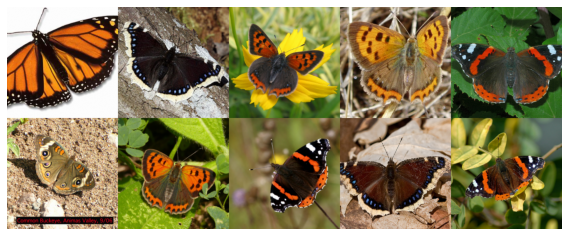

In [10]:
# Example dataloader usage
import matplotlib.pyplot as plt

# 1. set mode and shuffle
butterfly_dataloader.set_mode('train', True) 
#print(len(butterfly_dataloader)) # expect 745 train, 87 test for 832 total
imgs = []
count = 0
for i, (image, features, class_id) in enumerate((butterfly_dataloader)):
  #print(class_id) # We expect the first class id to be random when shuffle is true
                  # Here is where we would run whatever training iteration we wanted.
  imgs.append(image)
  count += 1
  if count >= 10:
    break
example_images = np.concatenate([np.concatenate(imgs[:5], axis=1), np.concatenate(imgs[5:], axis=1)], axis=0)
fig, ax = plt.subplots(figsize=(8, 4))
ax.imshow(example_images)
ax.axis('off')
plt.tight_layout()

## 2. Model Design + Training Procedure

Notice that we defined a feature extractor in our dataloader. This is because our feature extractor is static, and we don't want to repeat this process after we load data the first time. However, feature extraction is still part of our model design. Lets breakdown the model in a bit more detail:



The overall model design is a 2 step system which is common for many classification and regression models in machine learning. First we extract features from our images, then we train a classifier on these features that we extracted.

For the butterfly dataset, we first compute principle a few components from grayscale images, and then learn an LDA transformation for feature extraction.


For the MNIST dataset, we convert raw images into a single dimensional vector. From these vectors, we learn an LDA transformation, which we then pass to our classifier.

We are comparing 3 different classifiers: Logistic Regression, Multi Layer Perceptron, and AdaBoosted Decision Trees.



Logistic regression learns a linear combination of the features that predict a score. The range of this score defines what class we choose. For example, in two dimensions, classes are separated by which values lie above and below the red line:

`sklearn.linear_.LogisticRegression`

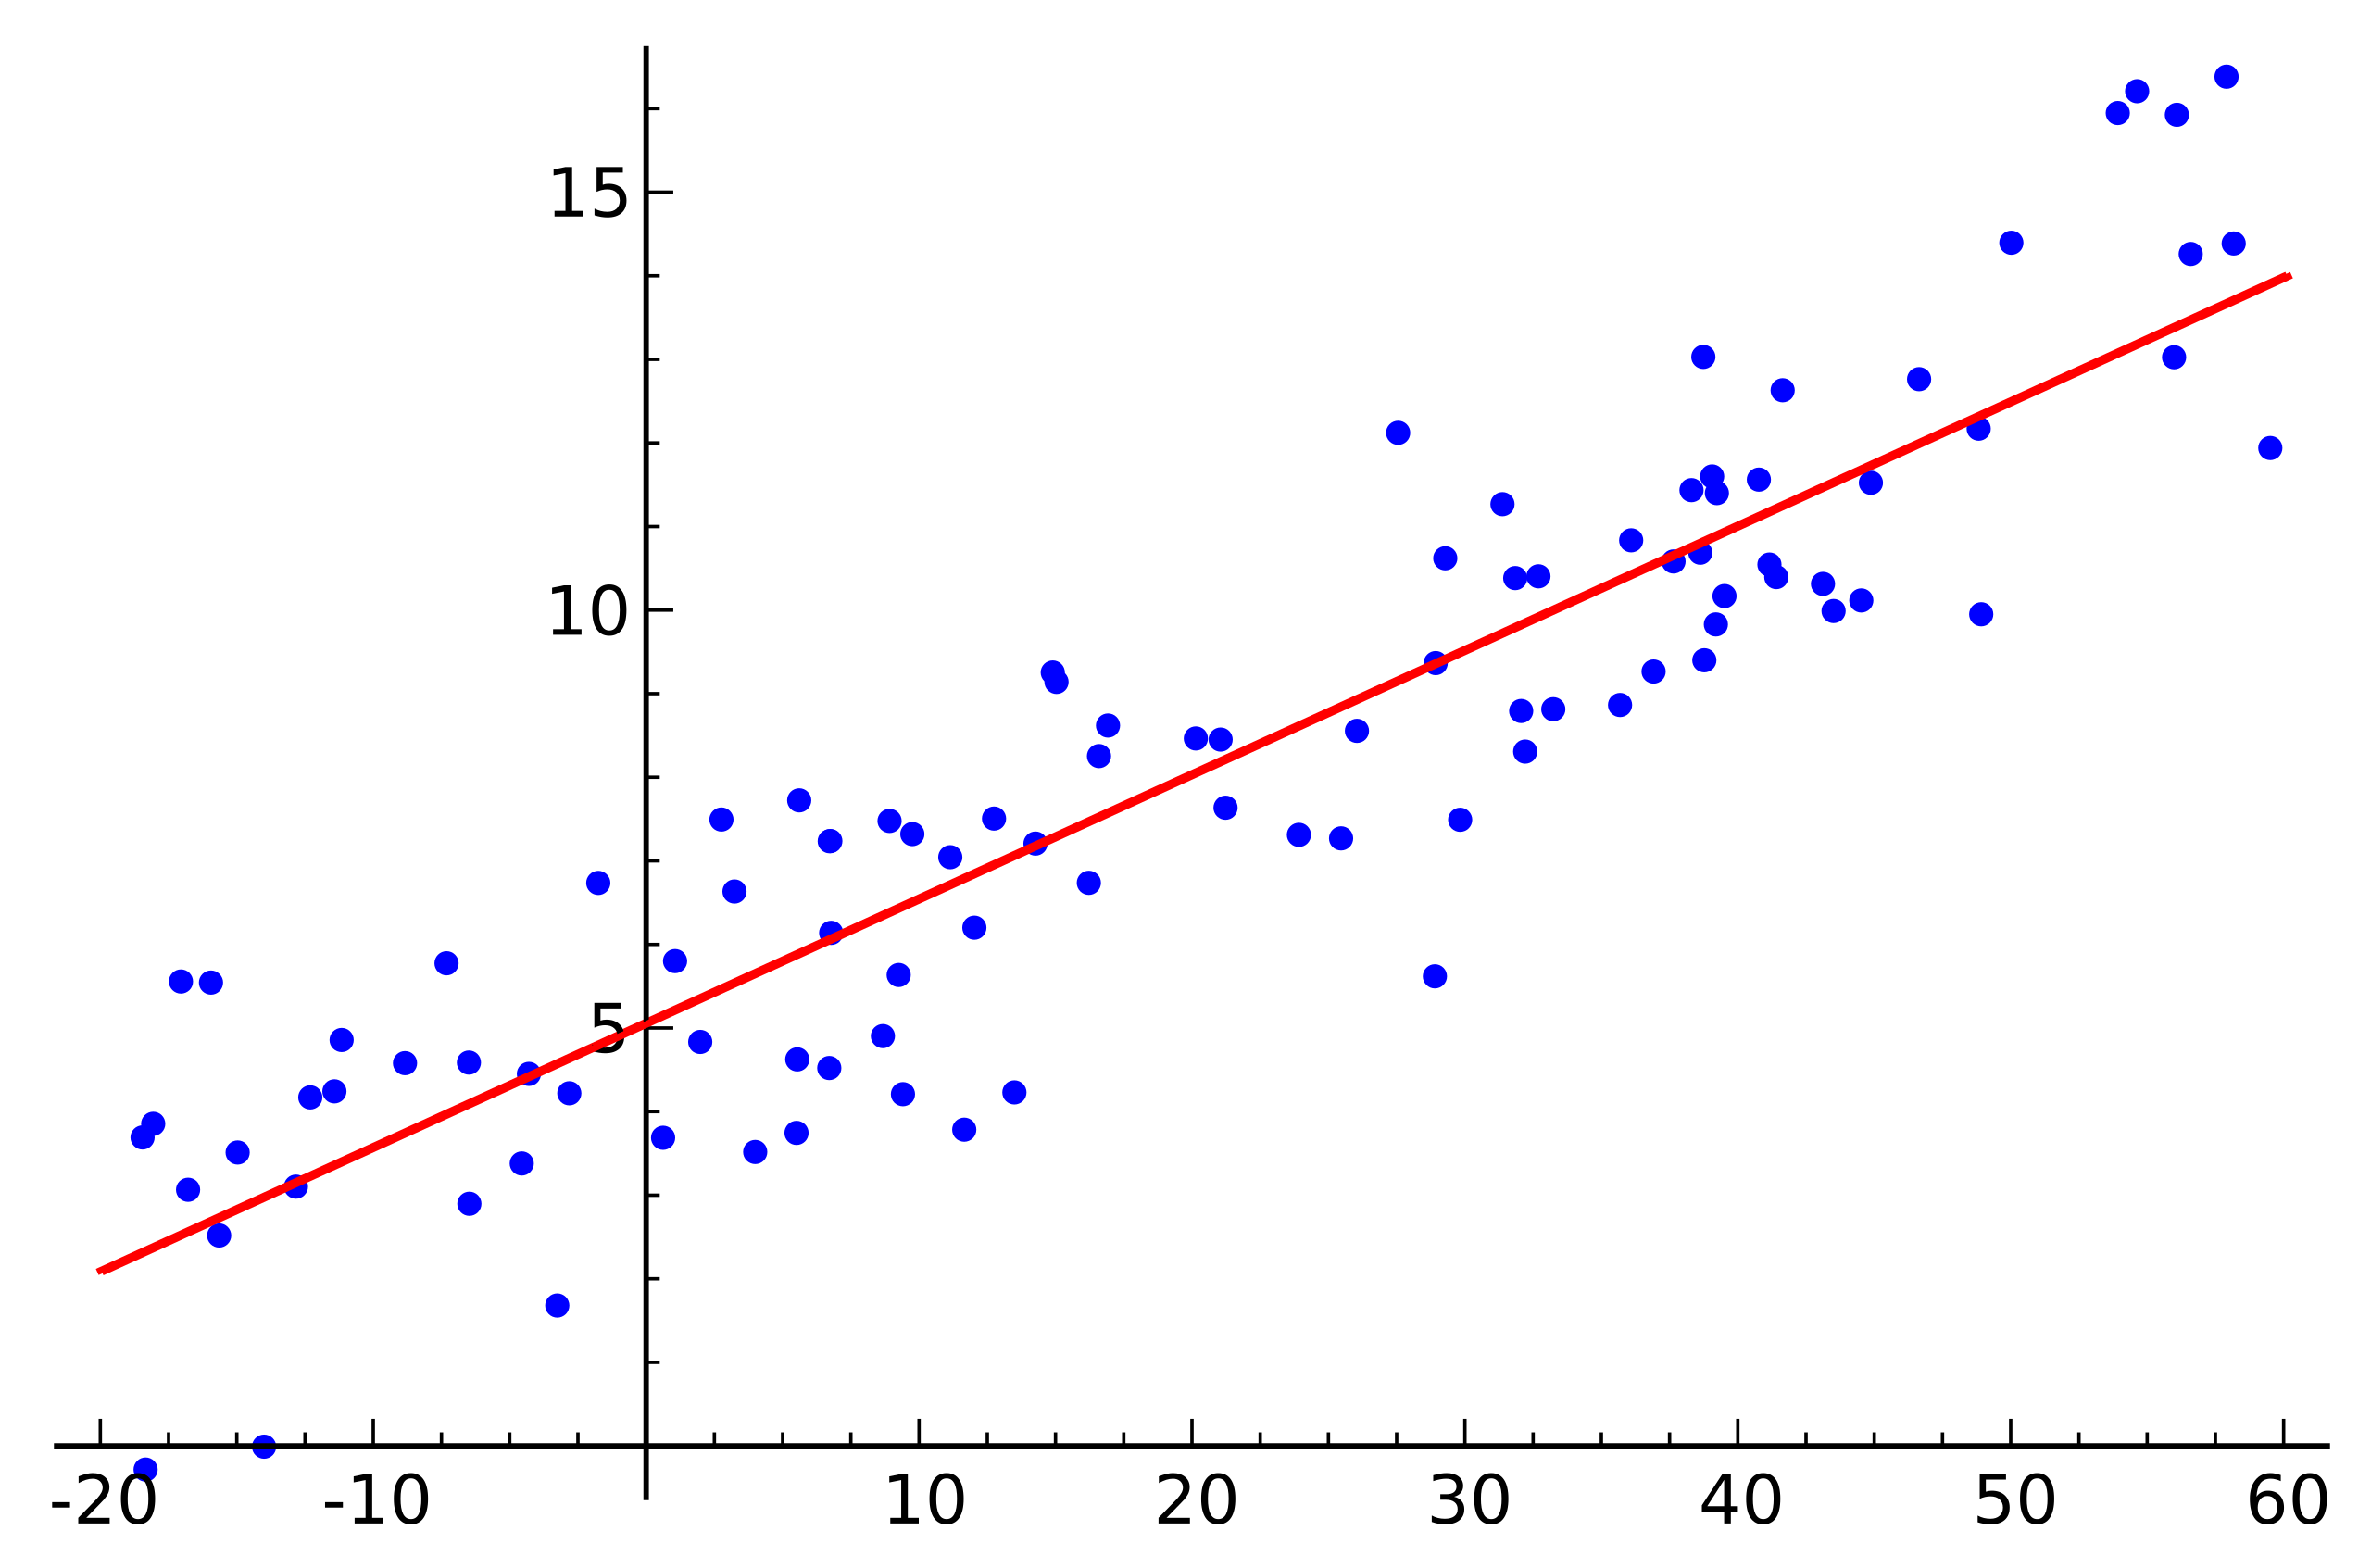

Multi-Layer perceptrons are networks of stacked single-dimensional neural layers. The outputs neuron(s) can be a single score on the class for single class recognition, or a set of scores on each class for multi-class recognition or classification.

From Stanford UFLDL Tutorial http://deeplearning.stanford.edu/tutorial/supervised/MultiLayerNeuralNetworks/

`sklearn.neural_network.MLPClassifier`

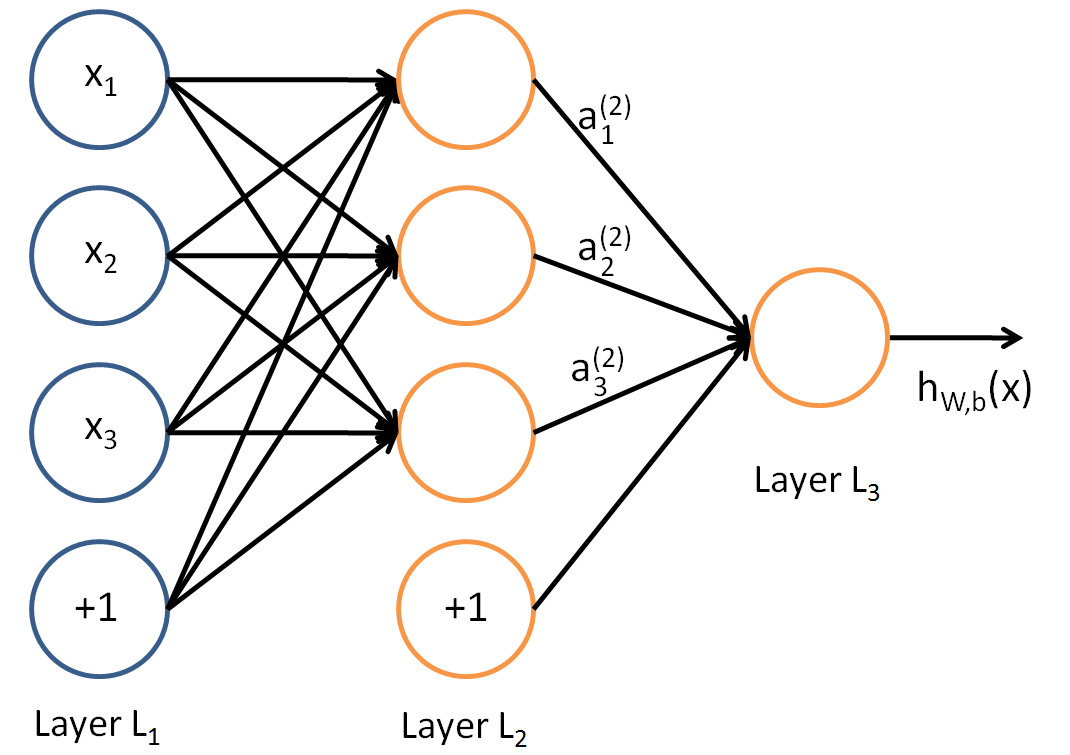

AdaBoost first fits a classifier on the data, and then fits additional copies of the classifier on the same data, but the weights of incorrectly classified instances are modified such that later classifiers focus on harder cases.



From Multi-class AdaBoost (Zhu et. al.) https://web.stanford.edu/~hastie/Papers/samme.pdf

`sklearn.ensemble.AdaBoostClassifier`

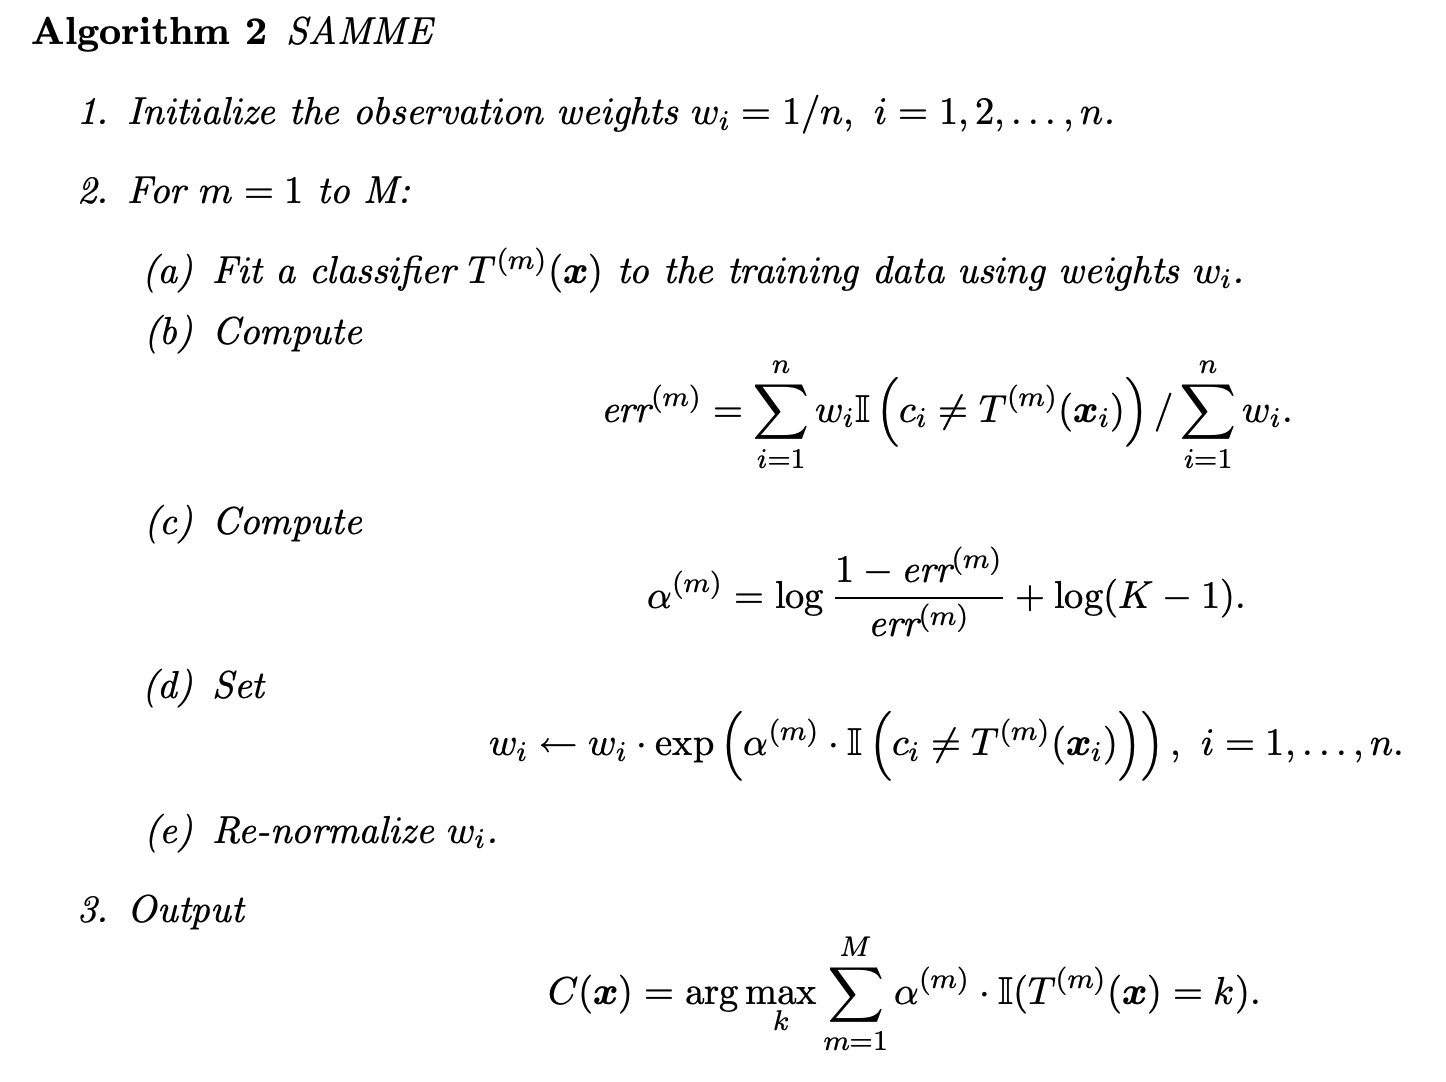

We use decision trees for each classifier, which logical develop trees on the parameters in which the leaves identify our output classes.

*Example Decision Tree on `sklearn` iris data*

`sklearn.tree.DecisionTreeClassifier`


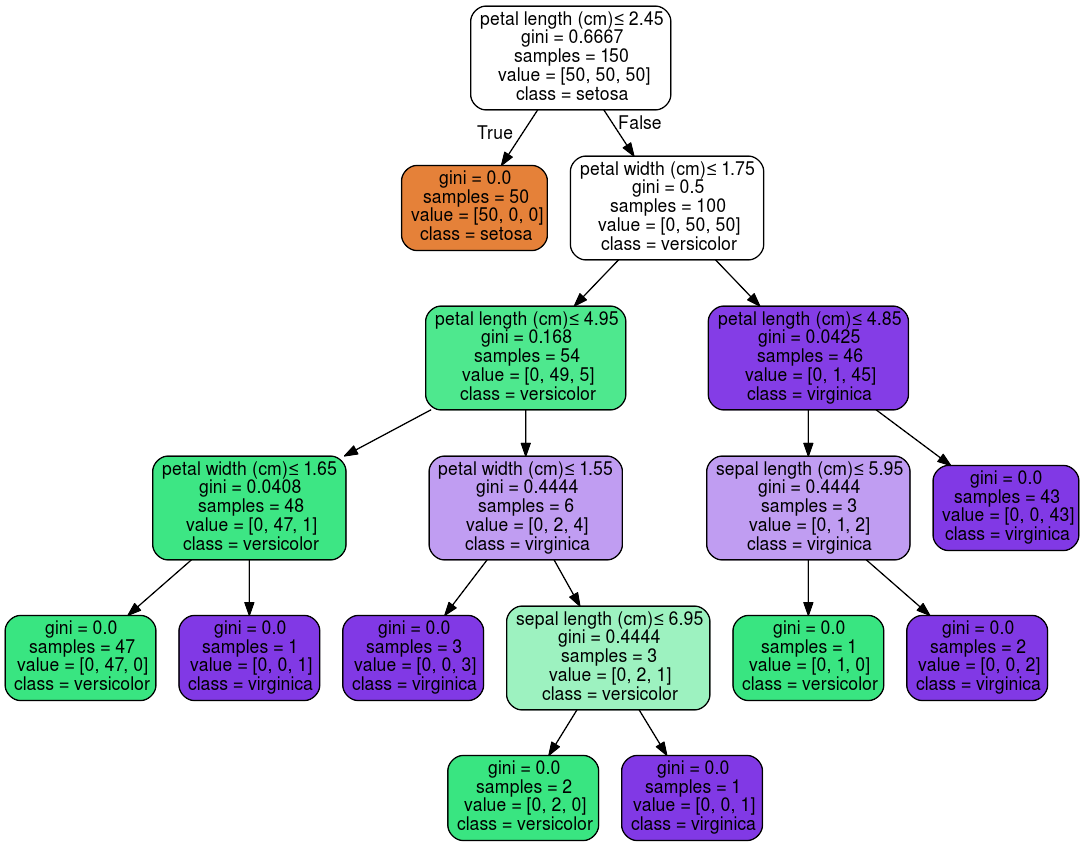

In [27]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
import numpy as np

def gather_features_leeds(all_classes, mode, shuffle):
  # Load preprocessed features from dataloader
  butterfly_dataloader.set_mode(mode, shuffle) 
  image_features = []
  classes = []
  for j, (image, features, class_id) in enumerate(butterfly_dataloader):
    if class_id not in all_classes:
      continue
    classes.append(list(all_classes).index(class_id))
    image_features.append(features)
  scaler = StandardScaler()
  classes = np.array(classes)
  image_features = np.stack(image_features, axis=0)
  return image_features, classes

def gather_features_mnist(mode):
  if mode == 'train':
    return MNIST_X_train, MNIST_y_train
  else:
    return MNIST_X_test, MNIST_y_test

def train(classifier, all_classes=None, data='MNIST', quiet=False, return_lda=False):
  # load train data
  if data == 'MNIST':
    if not quiet:
      print("TRAINING MNIST")
    train_features, train_classes = gather_features_mnist('train')
  else:
    if not quiet:
      print("TRAINING LEEDS")
    train_features, train_classes = gather_features_leeds(all_classes, 'train', True)
  # train LDA and train classifier
  lda = LinearDiscriminantAnalysis(n_components=1).fit(train_features, train_classes)
  train_features = lda.transform(train_features)
  classifier.fit(train_features, train_classes)

  # score train classification
  train_acc = classifier.score(train_features, train_classes)

  # load validation data
  if data == 'MNIST':
    val_features, val_classes = gather_features_mnist('test')
  else:
    val_features, val_classes = gather_features_leeds(all_classes, 'val', False)
  # transform LDA
  val_features = lda.transform(val_features)
  # score validation classification
  val_acc = classifier.score(val_features, val_classes)

  if return_lda:
    return train_acc, val_acc, lda
  return train_acc, val_acc

For sanity we want to make sure we're doing better than random, which would classify us into 1/N classes. Lets look at this training procedure when operating on 2 classes.

In [41]:
# select 2 random classes
all_classes = np.random.choice(range(1, 11), 2, replace=False)
features = 5
depth = 18
estimators = 15
classifier = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=depth),
    n_estimators=estimators,
    learning_rate=1.5,
    algorithm="SAMME"
)
t_acc, v_acc = train(classifier)
print("train_acc {} val acc {}, random {}".format(t_acc, v_acc, 1./10))
classifier = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=depth),
    n_estimators=estimators,
    learning_rate=1.5,
    algorithm="SAMME"
)
t_acc, v_acc = train(classifier, all_classes, 'LEEDS')
print("train_acc {} val acc {}, random {}".format(t_acc, v_acc, 1./2))


TRAINING MNIST
train_acc 0.8315333333333333 val acc 0.26, random 0.1
TRAINING LEEDS
train_acc 1.0 val acc 0.6111111111111112, random 0.5


In [40]:
from sklearn.linear_model import LogisticRegression
all_classes = np.random.choice(range(1, 11), 2, replace=False)
classifier = LogisticRegression(
                C=1000. / train_samples, penalty='l2', solver='saga', tol=0.1
             )
t_acc, v_acc = train(classifier)
print("train_acc {} val acc {}, random {}".format(t_acc, v_acc, 1./10))

classifier = LogisticRegression(
                C=1000. / len(butterfly_dataloader), penalty='l2', solver='saga', tol=0.01
             )
t_acc, v_acc = train(classifier, all_classes, 'LEEDS')
print("train_acc {} val acc {}, random {}".format(t_acc, v_acc, 1./2))

TRAINING MNIST
train_acc 0.11313333333333334 val acc 0.118, random 0.1
TRAINING LEEDS
train_acc 0.7017543859649122 val acc 0.6842105263157895, random 0.5


In [42]:
from sklearn.neural_network import MLPClassifier
all_classes = np.random.choice(range(1, 11), 2, replace=False)
classifier = MLPClassifier(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(15, 15), random_state=1, max_iter=10000, warm_start=True)
t_acc, v_acc = train(classifier)
print("train_acc {} val acc {}, random {}".format(t_acc, v_acc, 1./10))

classifier = MLPClassifier(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(15, 15), random_state=1, max_iter=10000, warm_start=True)
t_acc, v_acc = train(classifier, all_classes, 'LEEDS')
print("train_acc {} val acc {}, random {}".format(t_acc, v_acc, 1./2))

TRAINING MNIST
train_acc 0.3492 val acc 0.3435, random 0.1
TRAINING LEEDS
train_acc 0.9193548387096774 val acc 0.8666666666666667, random 0.5


## 3. Hyperparameter Tuning

Grid search is a commonly used method when tuning neural networks. Given modifiable parameters that define your model, it is often not sure what combination of parameters will yield the best result. The easiest, brute-force way to figure this out would be to iterate over all possible combinations of parameters. 

Because of the complexity of their algorithms, Adaboost and the multi layer perceptron make the most sense to search for parameters.

For Adaboost, this is the depth of the decision trees and the number of estimators.

For the 2-layer Perceptron, this is the size of the hidden layers.

In [43]:
ada_classifiers = []
t_accs, v_accs = [], []
random_acc = [1./N for N in range(2, 11)]
for c in range(2, 11):
  added = False
  best = ()
  best_v = 0
  for depth in range(2, 18, 2):
    for estimators in range(3, 15, 3):
      if c == 10:
        all_classes = np.array(range(1, 11))
      else:
        all_classes = np.random.choice(range(1, 11), c, replace=False)
      classifier = AdaBoostClassifier(
          DecisionTreeClassifier(max_depth=depth),
          n_estimators=estimators,
          learning_rate=1.5,
          algorithm="SAMME"
      )
      t_acc, v_acc, lda = train(classifier, all_classes, "LEEDS", True, True)
      if v_acc > best_v:
        best = (t_acc, v_acc)
        if added:
          ada_classifiers[-1] = (classifier, lda)
        else:
          ada_classifiers.append((classifier, lda))
          added = True
  t_accs.append(best[0])
  v_accs.append(best[1])
  print("{}: train acc {} val acc {} random {}".format(c, best[0], best[1], 1./c))


2: train acc 1.0 val acc 0.5789473684210527 random 0.5
3: train acc 0.9666666666666667 val acc 0.4074074074074074 random 0.3333333333333333
4: train acc 0.9933993399339934 val acc 0.34285714285714286 random 0.25
5: train acc 1.0 val acc 0.3023255813953488 random 0.2
6: train acc 1.0 val acc 0.3392857142857143 random 0.16666666666666666
7: train acc 1.0 val acc 0.22413793103448276 random 0.14285714285714285
8: train acc 1.0 val acc 0.11764705882352941 random 0.125
9: train acc 1.0 val acc 0.19230769230769232 random 0.1111111111111111
10: train acc 1.0 val acc 0.14942528735632185 random 0.1


In [44]:
import random
mlp_classifiers = []
t_accs_mlp, v_accs_mlp = [], []
random_acc = [1./N for N in range(2, 11)]
for c in range(2, 11):
  added = False
  for hidden in range(5, 20, 5):
    best = ()
    best_v = 0
    if c == 10:
      all_classes = np.array(range(1, 11))
    else:
      all_classes = np.random.choice(range(1, 11), c, replace=False)
    features = 5
    depth = 18
    estimators = 15
    classifier =  MLPClassifier(solver='lbfgs', alpha=1e-5,
                hidden_layer_sizes=(hidden, hidden), random_state=1,
                max_iter=10000, warm_start=True, early_stopping=True
    )
    t_acc, v_acc, lda = train(classifier, all_classes, 'LEEDS', True, True)
    if v_acc > best_v:
      best = (t_acc, v_acc)
      if added:
        mlp_classifiers[-1] = (classifier, lda)
      else:
        mlp_classifiers.append((classifier, lda))
  t_accs_mlp.append(best[0])
  v_accs_mlp.append(best[1])
  print("{}: train acc {} val acc {} random {}".format(c, best[0], best[1], 1./c))


2: train acc 0.8050314465408805 val acc 0.9444444444444444 random 0.5
3: train acc 0.6896551724137931 val acc 0.5416666666666666 random 0.3333333333333333
4: train acc 0.44135802469135804 val acc 0.3783783783783784 random 0.25
5: train acc 0.45231607629427795 val acc 0.3488372093023256 random 0.2
6: train acc 0.38823529411764707 val acc 0.3 random 0.16666666666666666
7: train acc 0.33081285444234404 val acc 0.3114754098360656 random 0.14285714285714285
8: train acc 0.29605263157894735 val acc 0.21428571428571427 random 0.125
9: train acc 0.2897897897897898 val acc 0.23076923076923078 random 0.1111111111111111
10: train acc 0.25771812080536916 val acc 0.27586206896551724 random 0.1


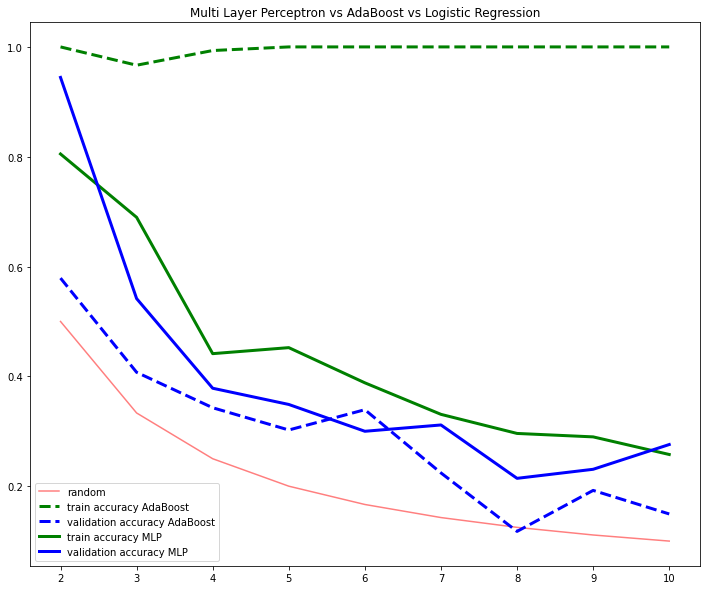

In [45]:
fig, ax = plt.subplots(figsize=(12, 10))
ax.plot(range(2, 11), random_acc, '#FF000080', label="random")
ax.plot(range(2, 11), t_accs, '#008000FF', linestyle='--', linewidth=3.0, label="train accuracy AdaBoost")
ax.plot(range(2, 11), v_accs, '#0000FFFF', linestyle='--', linewidth=3.0, label="validation accuracy AdaBoost")
ax.plot(range(2, 11), t_accs_mlp, '#008000FF', linestyle='-',linewidth=3.0, label="train accuracy MLP")
ax.plot(range(2, 11), v_accs_mlp, '#0000FFFF', linestyle='-', linewidth=3.0, label="validation accuracy MLP")
ax.set_title('Multi Layer Perceptron vs AdaBoost vs Logistic Regression')
plt.legend()
plt.show()

In [46]:
butterfly_dataloader.set_mode('val', True)

# in hindsight, this breakdown is excessive.
examples = {
    'ada': {
        'success': {i: [] for i in range(1, 11)},
        'failure': {i: [] for i in range(1, 11)},
        'labels_success': {i: [] for i in range(1, 11)},
        'labels_failure_pred': {i: [] for i in range(1, 11)},
        'labels_failure_gt': {i: [] for i in range(1, 11)},
        'complete': {j: [False for i in range(1, 11)] for j in ['success', 'failure']},
     },
     'mlp': {
        'success': {i: [] for i in range(1, 11)},
        'failure': {i: [] for i in range(1, 11)},
        'labels_success': {i: [] for i in range(1, 11)},
        'labels_failure_pred': {i: [] for i in range(1, 11)},
        'labels_failure_gt': {i: [] for i in range(1, 11)},
        'complete': {j: [False for i in range(1, 11)] for j in ['success', 'failure']},
     }
}

for k in range(9):
  if (np.array(examples['ada']['complete']['success']).all() and
      np.array(examples['ada']['complete']['failure']).all() and
      np.array(examples['mlp']['complete']['success']).all() and
      np.array(examples['mlp']['complete']['failure']).all()):
      break
  ada_classifier, ada_lda = ada_classifiers[k]
  mlp_classifier, mlp_lda = mlp_classifiers[k]
  # plot some success and failure examples from each class
  for i, (image, features, class_id) in enumerate(butterfly_dataloader):
    features_ada = ada_lda.transform(features.reshape(1, 15))
    features_mlp = mlp_lda.transform(features.reshape(1, 15))
    pred_ada = int(ada_classifier.predict(features_ada.reshape(-1, 1)))
    pred_mlp = int(mlp_classifier.predict(features_mlp.reshape(-1, 1)))
    
    success_ada = pred_ada == class_id
    success_mlp = pred_mlp == class_id
    if not success_ada and not examples['ada']['complete']['failure'][class_id-1]:
        examples['ada']['failure'][class_id].append(image)
        examples['ada']['labels_failure_pred'][class_id].append(butterfly_classes[pred_mlp-1])
        examples['ada']['labels_failure_gt'][class_id].append(butterfly_classes[class_id-1])
        if len(examples['ada']['failure'][class_id]) >= 1:
          examples['ada']['complete']['failure'][class_id-1] = True
      # ada failure
    elif success_ada and not examples['ada']['complete']['success'][class_id-1]:
        examples['ada']['success'][class_id].append(image)
        examples['ada']['labels_success'][class_id].append(butterfly_classes[class_id-1])
        if len(examples['ada']['success'][class_id]) >= 1:
          examples['ada']['complete']['success'][class_id-1] = True
      # ada success
    elif not success_mlp  and not examples['mlp']['complete']['failure'][class_id-1]:
        examples['mlp']['failure'][class_id].append(image)
        examples['mlp']['labels_failure_pred'][class_id].append(butterfly_classes[pred_mlp-1])
        examples['mlp']['labels_failure_gt'][class_id].append(butterfly_classes[class_id-1])
        if len(examples['mlp']['failure'][class_id]) >= 1:
          examples['mlp']['complete']['failure'][class_id-1] = True
      # mlp failure
    elif not examples['mlp']['complete']['success'][class_id-1]:
        examples['mlp']['success'][class_id].append(image)
        examples['mlp']['labels_success'][class_id].append(butterfly_classes[class_id-1])
        if len(examples['mlp']['success'][class_id]) >= 1:
          examples['mlp']['complete']['success'][class_id-1] = True
      # mlp success

In [47]:
count_success_mlp = 0
count_failure_mlp = 0
count_success_ada = 0
count_failure_ada = 0
for c in range(10):
  try:
    image_success_mlp = examples['mlp']['success'][c][0]
    label_success_mlp = examples['mlp']['labels_success'][c][0]
    fig, ax = plt.subplots(figsize=(3, 3))
    ax.imshow(image_success_mlp)
    ax.set_title('MLP Success:\n {}'.format(label_success_mlp))
    ax.axis('off')
    ax.titlesize = 72
    plt.tight_layout()
    plt.savefig('success_mlp_{}.png'.format(count_success_mlp))
    count_success_mlp += 1
    plt.close()
  except:
    continue
  try:
    image_success_ada = examples['ada']['success'][c][0]
    label_success_ada = examples['ada']['labels_success'][c][0]
    fig, ax = plt.subplots(figsize=(3, 3))
    ax.imshow(image_success_ada)
    ax.set_title('AdaBoost Success:\n {}'.format(label_success_mlp))
    ax.axis('off')
    ax.titlesize = 72
    plt.tight_layout()
    plt.savefig('success_ada_{}.png'.format(count_success_ada))
    count_success_ada += 1
    plt.close()
  except:
    pass
  try:
    image_failure_mlp = examples['mlp']['failure'][c][0]
    label_failure_mlp_gt = examples['mlp']['labels_failure_gt'][c][0]
    label_failure_mlp_pred = examples['mlp']['labels_failure_pred'][c][0]
    fig, ax = plt.subplots(figsize=(3, 3))
    ax.imshow(image_failure_mlp)
    ax.set_title('MLP Failure\nGuess: {}\nTruth: {}'.format(label_failure_mlp_pred, label_failure_mlp_gt))
    ax.titlesize = 52
    ax.axis('off')
    plt.tight_layout()
    plt.savefig('failure_mlp_{}.png'.format(count_failure_mlp))
    count_failure_mlp += 1
    plt.close()
  except:
    pass
  try:
    image_failure_ada = examples['ada']['failure'][c][0]
    label_failure_ada_gt = examples['ada']['labels_failure_gt'][c][0]
    label_failure_ada_pred = examples['ada']['labels_failure_pred'][c][0]
    fig, ax = plt.subplots(figsize=(3, 3))
    ax.imshow(image_failure_ada)
    ax.set_title('AdaBoost Failure\nGuess: {}\nTruth: {}'.format(label_failure_ada_pred, label_failure_ada_gt))
    ax.axis('off')
    ax.titlesize = 52
    plt.tight_layout()
    plt.savefig('failure_ada_{}.png'.format(count_failure_ada))
    count_failure_ada += 1
    plt.close()
  except:
    pass

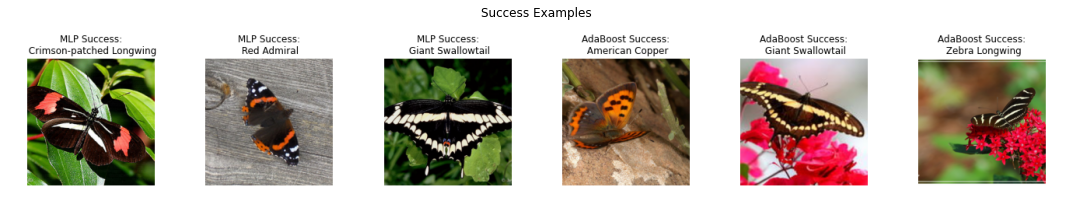

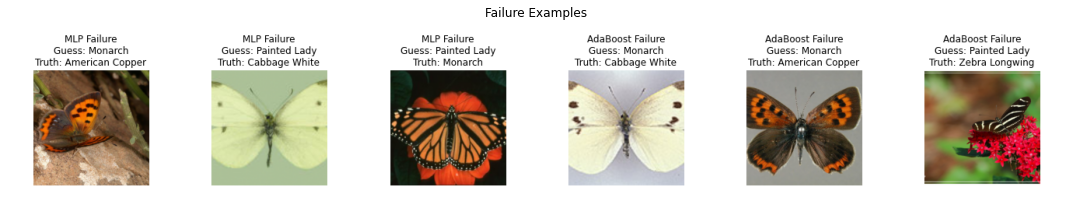

In [48]:
# success plot
fig, ax = plt.subplots(nrows=1, ncols=6, figsize=(15, 3))
rng = list(range(count_success_mlp))
random.shuffle(rng)
for i, idx in enumerate(rng[:3]):
  ax[i].imshow(plt.imread('success_mlp_{}.png'.format(idx)))
  ax[i].axis('off')
rng = list(range(count_success_ada))
random.shuffle(rng)
for i, idx in enumerate(rng[:3]):
  ax[i+3].imshow(plt.imread('success_ada_{}.png'.format(idx)))
  ax[i+3].axis('off')
plt.tight_layout()
plt.suptitle('Success Examples')
plt.show()

fig, ax = plt.subplots(nrows=1, ncols=6, figsize=(15, 3))
rng = list(range(count_failure_mlp))
random.shuffle(rng)
for i, idx in enumerate(rng[:3]):
  ax[i].imshow(plt.imread('failure_mlp_{}.png'.format(idx)))
  ax[i].axis('off')
rng = list(range(count_failure_ada))
random.shuffle(rng)
for i, idx in enumerate(rng[:3]):
  ax[i+3].imshow(plt.imread('failure_ada_{}.png'.format(idx)))
  ax[i+3].axis('off')
plt.tight_layout()
plt.suptitle('Failure Examples')
plt.show()

Notice that the training accuracy for the AdaBoosted decision tree is high, while validation accuracy suffers. This is due to the fact that the AdaBoosted model has overfit the training data, which is common for deterministic models with lots of parameters that do not incorporate more nuanced features, like convolutional feature detectors. The multi layer perceptron performs better, whichh we expect because of theh complexity of the neural network, which allows for more complex combinations of model parameters when performing classification.

One more thing to note is that we suffer siginifcantly as we add more classes to our classifiers. Thats because the models we use are very simple--there are no overly complicated feature extractors, convolutional layers, or even deep networks. In the next video, we'll be looking at some of those more powerful models using the tensorflow library. 

## 4. Additional Examples, Tutorials and Extended Learning

Sklearn provides easy-to-use, simple machine learning algorithms, however, they may not be powerful enough for your application.Check out the [documentation](https://scikit-learn.org/stable/user_guide.html) for more detailed information on all the models available.



[Next time,](https://www.youtube.com/channel/UCvVAxOBEAMgu7WwTcFptt-w?sub_confirmation=1) we're going to talk about Tensorflow, one of the most popular machine learning frameworks for hardware accelerated deep learning.